Задание:

1. Подмешать к вами уже обученной модели новые классы и посмотреть как они разнесены.
2. Посчитать центроиды классов и допустимый радиус от центроида. Сформировать табличку класс/коордианты центроида/радиус (евклидово расстояние)
3. Посчитать число ошибочной классификации используя центроид и радиус на тестовой выборке. Сформировать табличку результата
4. Понизить размерность вектора используя maxpooling1d до 160
5. Посчитать новые центры и радиусы, и протестировать на тестовой выборке, сравнить число ошибок с результатами из п.3

# **Подготовка**

## Установка

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # Подключим google disk

Mounted at /content/drive


In [ ]:
#!unzip -oq 'drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataSet/animals-10.zip' -d 'drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataSet/animals-10' # Разархивируем zip.

In [ ]:
import tensorflow as tf
from pathlib import Path
from datetime import datetime   # Библиотека для подписывания времени
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split    # Для разбития датасета.
import pandas as pd   # Импорт пандас
from tqdm import tqdm   # Для полоски статус бар.

import albumentations as A
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from shutil import rmtree

tqdm.pandas()   # Подключение статус бар для работы с пандас


device_name = tf.test.gpu_device_name()   # Проверка на наличие видеокарты
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#   Зададим константы
IMAGE_SIZE = (224,224,3)    # Размер рабочего изображения(высота и нирина) и количество каналов
MODELS_DIR = Path('drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/MultiLabelClassification')   # Путь для сохранения моделей
MODELS_DIR.mkdir(parents=True, exist_ok=True)   #Создадим папку по заданному пути, если её нет.
DATASET_DIR = Path('drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataSet/animals-10/raw-img')   # Путь для датасета

In [ ]:
# Создадим датафрейм куда будем писать результаты экспериментов

df_results = pd.DataFrame(columns=['Model_name', 'Loss', 'Accuracy', 'time_one_jpg'])

##TF.DATA

### Выполняем запуск с этого места, при первом запуске, без сохранённых данных.

3 Способ.

Мы создаем csv файлы с train, val и test(если надо). В них сохраняем раскладку картинок и в будущем подгружаем tf.Data

In [ ]:
from PIL import Image

def is_image_corrupted(filepath):
  try:
    with image.open(filepath) as im:
      im.verify()
    return False
  except:
    return True

26182it [01:13, 358.46it/s] 


Label_i
0          cane
1       cavallo
2      elefante
3      farfalla
4       gallina
5         gatto
6         mucca
7        pecora
8         ragno
9    scoiattolo
Name: Label, dtype: object


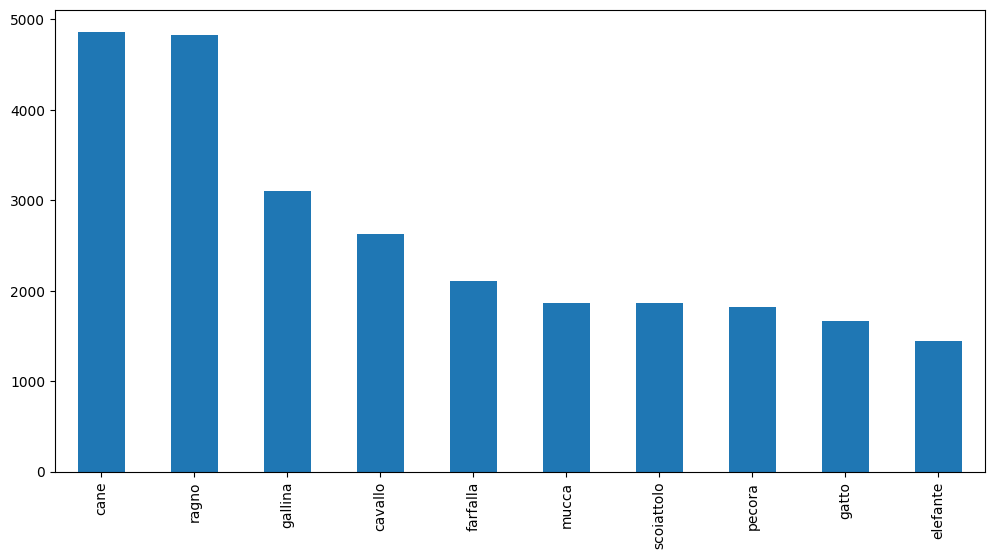

In [ ]:
files = [(file.as_posix(), file.parent.name) for file in tqdm(DATASET_DIR.glob('**/*.*')) if (file.suffix in ['.jpg', '.jpeg', '.png'] and is_image_corrupted(file))]
#files = [(file.as_posix(), file.parent.name) for file in FULLSET_DIR.glob('**/*.jpg')]
df_dataset = pd.DataFrame(data=files,
                          columns=['File', 'Label'])
df_dataset['Label_i'] = df_dataset['Label'].astype('category').cat.codes

df_dataset['Label'].value_counts().plot(kind='bar', figsize=(12,6))
index_to_label = df_dataset.groupby('Label_i')['Label'].first()
print(index_to_label)

In [ ]:
df_dataset

File       Label  Label_i
0      drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...        cane        0
1      drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...        cane        0
2      drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...        cane        0
3      drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...        cane        0
4      drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...        cane        0
...                                                  ...         ...      ...
26174  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  scoiattolo        9
26175  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  scoiattolo        9
26176  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  scoiattolo        9
26177  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  scoiattolo        9
26178  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  scoiattolo        9

[26179 rows x 3 columns]

In [ ]:
# Сделаем разбиение в соотношении 60-20-20
# Разобьём df_dataset на тренировочную (train_un) и промежуточную валидационную (valid) выборки.
train_un, valid = train_test_split(df_dataset, test_size=0.4, stratify=df_dataset['Label_i'], random_state=89)
# Разобьём valid на валидационную (val) и тестовую (test) выборки.
val, test = train_test_split(valid, test_size=0.5, stratify=valid['Label_i'], random_state=89)
# Посмотрим что получилось.
print(f"{train_un.shape=}, {val.shape=}, {test.shape=}")

train_un.shape=(15707, 3), val.shape=(5236, 3), test.shape=(5236, 3)


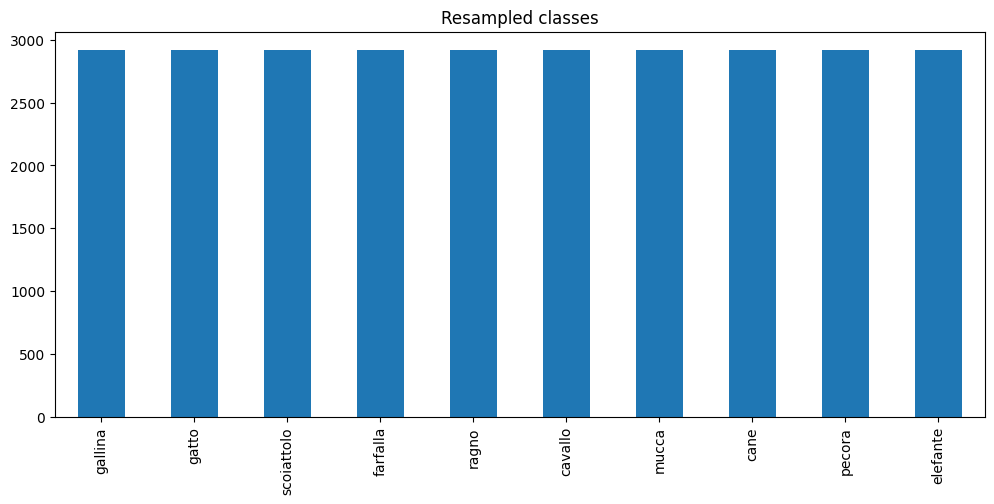

Total positive items: 34416
Train: 29180, val: 5236


In [ ]:
ROS = RandomOverSampler(sampling_strategy='auto')
train, _ = ROS.fit_resample(train_un, train_un['Label'])
train['Label'].value_counts().plot.bar(figsize=((12,5)), title='Resampled classes')
plt.show()

print(f'Total positive items: {len(train)+len(val)}')
print(f'Train: {len(train)}, val: {len(val)}')

In [ ]:
# Запишем выборки в файл.
train.to_csv(DATASET_DIR.joinpath('train.csv'), index=False)
val.to_csv(DATASET_DIR.joinpath('val.csv'), index=False)
test.to_csv(DATASET_DIR.joinpath('test.csv'), index=False)

### Запуск при уже обученной модели

In [ ]:
# Загрузим данные из файлов и посмотрим.
import pandas as pd

train_df = pd.read_csv(DATASET_DIR.joinpath('train.csv'))
val_df = pd.read_csv(DATASET_DIR.joinpath('val.csv'))
test_df = pd.read_csv(DATASET_DIR.joinpath('test.csv'))

print(f"train_df = {train_df.shape}, val_df = {val_df.shape}, test_df = {test_df.shape}")

train_df = (29180, 3), val_df = (5236, 3), test_df = (5236, 3)


In [ ]:
train_df = train_df.groupby('Label').head(500)
train_df['Label'].value_counts()

gallina       500
gatto         500
scoiattolo    500
farfalla      500
ragno         500
cavallo       500
mucca         500
cane          500
pecora        500
elefante      500
Name: Label, dtype: int64

In [ ]:
def load_image(image_path, label):    # Функция принимает 2 параметра: путь и метку.
    image = tf.io.read_file(image_path)   # Считываем файл по пути image_path
    image = tf.image.decode_image(image, channels=3, expand_animations=False)   # Декодируем файл, превращая в изображение и плюс 3 канала.
    image = tf.image.resize(image, size=IMAGE_SIZE[:2])   # Сделаем преобразование изображения в нужный размер.
    image = tf.cast(image, tf.float32)    # Указываем явно тип данных во float32
    return image, label   # На выход выдаём рисунок и метку.

# Формируем пандасовский dataframe из столбцов (путь к картинке и соответствующая ей метка).
train_ds = tf.data.Dataset.from_tensor_slices((train_df['File'].values, train_df['Label_i'].values))

# Перемешиваем данные (путь к картинке и соответствующая ей метка).
train_ds = train_ds.shuffle(buffer_size=len(train_ds), reshuffle_each_iteration=True)
# С помошью метода map применим функцию load_image ко всем данным построчно.
train_ds = train_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)
# num_parallel_calls - распаралеливание процессов при подготовки данных
# Размер батча(пачка из n-го количества изображений, что-бы сразу подавать в модель n изображений)
# prefetch - позволяеет подгружать данные наперёд.

val_ds = tf.data.Dataset.from_tensor_slices((val_df['File'].values, val_df['Label_i'].values))
val_ds = val_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)

test_ds = tf.data.Dataset.from_tensor_slices((test_df['File'].values, test_df['Label_i'].values))
test_ds = test_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)

# TODO test_ds

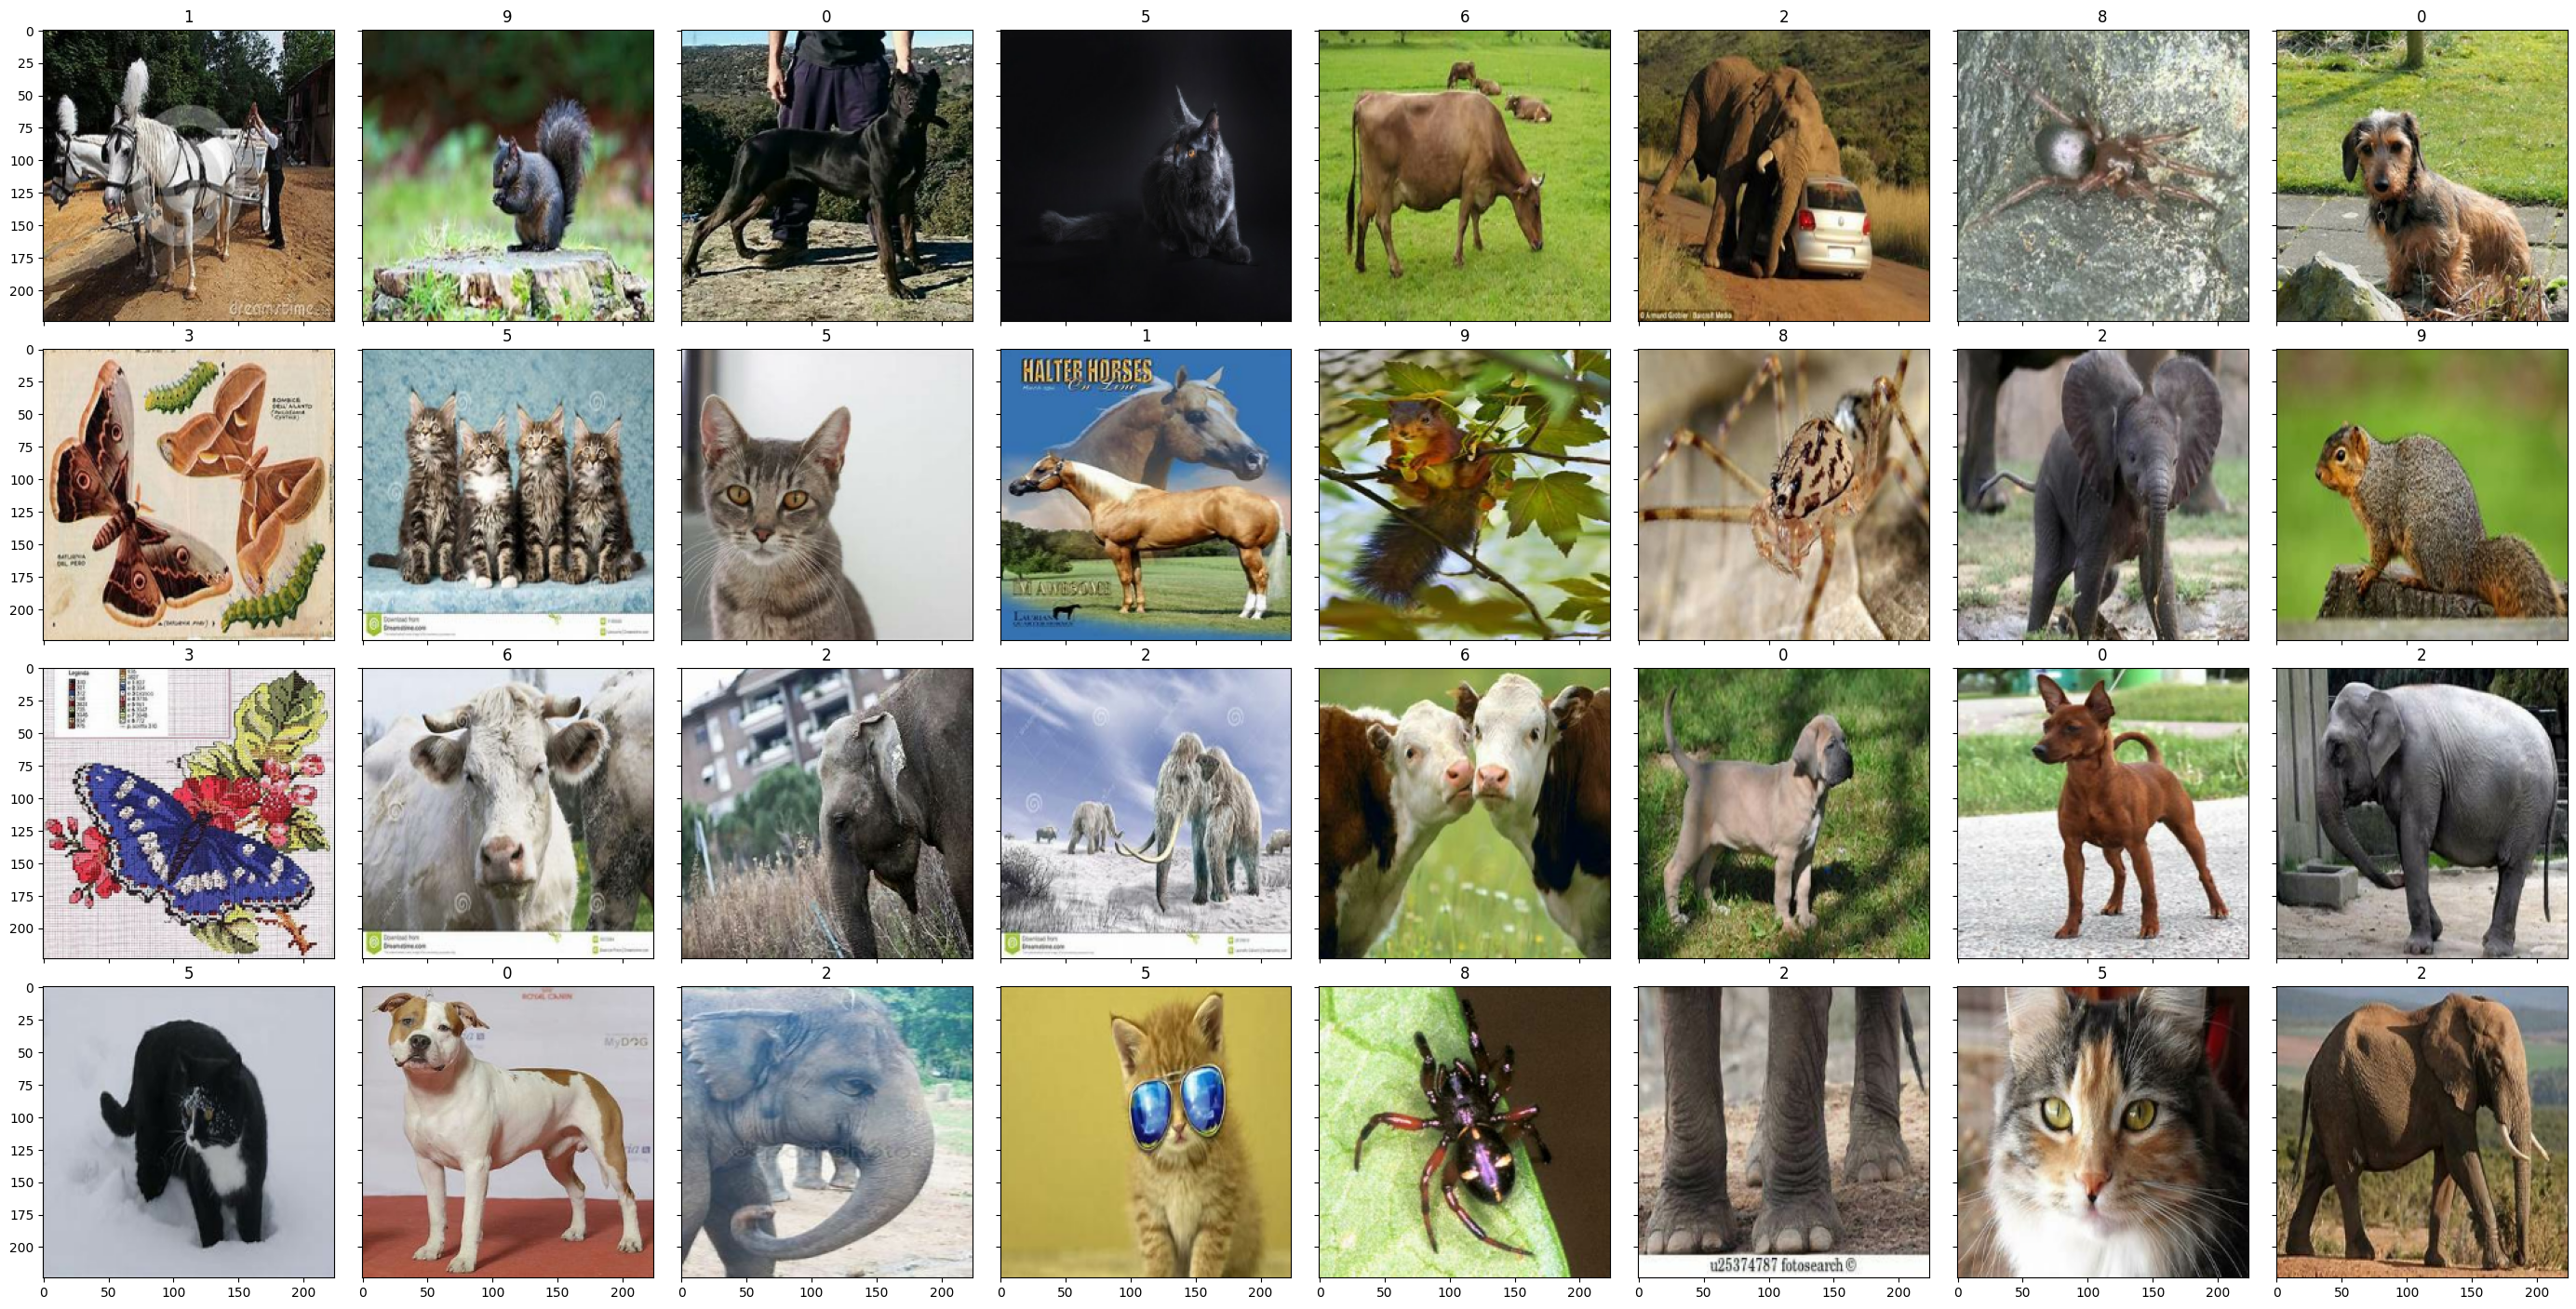

In [ ]:
im_batch_plus_lbl, lbl_batch = next(iter(train_ds))
im_batch = im_batch_plus_lbl

fig = plt.figure(figsize=(35, 35))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )
for i, grid in enumerate(zip(grid, im_batch)):
    ax, im = grid
    ax.imshow(tf.cast(im,tf.int32))
    ax.set_title(lbl_batch[i].numpy(), fontdict=None, loc='center', color = "k")

plt.show()

##CALLBACKS

In [ ]:
def generate_callbacks():
    MODELS_DIR.joinpath('cp').mkdir(parents=True, exist_ok=True)
    MODELS_DIR.joinpath('logs').mkdir(parents=True, exist_ok=True)

    reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.2,
                                            patience=2,
                                            verbose=1,
                                            min_delta=0.000001,
                                            cooldown=0,
                                            min_lr=0.0000001)

    chk_path = MODELS_DIR.joinpath('cp', 'ckpt_{epoch:02d}.ckpt')

    # Ключевые точки обучения. Если save_best_only=True (модель улучшилась), то эти точки сохраняем. save_weights_only=True -сохранение только веса модели.
    checkpointer = tf.keras.callbacks.ModelCheckpoint(chk_path, save_best_only=True, verbose=1, save_weights_only=True)

    # monitor='val_loss' - на основании чего срабатывает (на основании валидационной ошибки). Если валидационная ошибка не уменьшается
    # на протяжении 4 эпох(patience=4), то обучение останавливается. min_delta=0.0001 - на сколько должна улучшиться модель,
    # что-бы мы считали её улучшиной. restore_best_weights=True - запоминает когда была самая лучшая эпоха и после остановки восстановит эту точку.
    stopper = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, min_delta=0.0001, verbose=1)

    # Ведение логирования и запись обучения, каждую эпоху, в csv файл.
    logger = CSVLogger(MODELS_DIR.joinpath("logs", f"training_log.csv"), separator=';', append=True)

    logs = "logs/" + datetime.now().strftime("thresh_%Y%m%d-%H%M%S")
    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                    histogram_freq = 1,
                                                    profile_batch = '200,205')


    callbacks = [reduce_learning_rate,    # автоматическое уменьшение шага обучения
                checkpointer,   # Ключевые точки обучения
                stopper,    # Остановка обучения
                logger,   # Логирование
    ]
    return callbacks

callbacks = generate_callbacks()    # вызываем для перегенирации collbacks.
print('Done')

Done


## Создадим функцию аугоментации.

In [ ]:
# Создадим функцию аугоментации
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),    # Случайное отображение по горизонтали (влево или вправо)
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),         # Случайное вращение
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),             # Случайное изменение размера
    ],
    name='augmentation'

)

## Создадим функцию для показа графиков обучения.

In [ ]:
# Функция для показа графиков обучения
import matplotlib.pyplot as plt

def show_results(history):
    accuracy = history.history['sparse_categorical_accuracy']
    val_accuracy = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(accuracy)+1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.legend()
    plt.title("Training and validation accuracy")
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.legend()
    plt.title("Training and validation loss")
    plt.show()




#**MobileNetV2**

## Ниже представлено обучение с трансферлернингом

1. Подцепляем к предобученному замороженному backbone выходную голову и обучаем
2. Размораживаем часть ближайших слоев к голове и малым шагом дообучаем их

In [ ]:

# Создадим свёрточный слой на основании MobileNetV2
conv_base = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE,
                                           include_top=False,
                                           pooling='avg',
                                           alpha=0.35,
                                           weights='imagenet',
                                           )

# Передаём этот параметр, чтобы модель изначально не обучалась
conv_base.trainable=False


# Формируем модель
input = tf.keras.Input(IMAGE_SIZE)    # входной слой
x = data_augmentation(input)          # Слой аугументации
x = x/255.                            # Нормализация
x = conv_base(x)                      # Созданный свёрточный слой
x = tf.keras.layers.Flatten()(x)      # Слой сглаживания
# Это для МУЛЬТИКЛАССОВОЙ КЛАССИФИКАЦИИ
output = tf.keras.layers.Dense(len(index_to_label), activation='sigmoid')(x)    # полносвязный слой, который имеет несколько выходов (в данном случае,
                                                                                # количество = количество меток) и функцию активации сигмоида
                                                                                # (значение от 0 до 1).

# Это для БИНАРНОЙ КЛАССИФИКАЦИИ
#output = tf.keras.layers.Dense(1, activation='sigmoid')(x)    # полносвязный слой, который имеет один выход
                                                              # и функцию активации сигмоида (значение от 0 до 1)


# Создаём модель
model_two_steps_Animals_10 = tf.keras.Model(inputs=input, outputs=output, name="Two_steps_learning_Animals_10")
# Смотрим какую модель создали
model_two_steps_Animals_10.summary()
# Компилируем мордель
model_two_steps_Animals_10.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                   loss = tf.keras.losses.SparseCategoricalCrossentropy(),           # Функция потерь для мультиклассовой классификации.
                                   #loss='binary_crossentropy',                                      # Функция потерь для бинарной классификации.
                                   metrics= [tf.keras.metrics.SparseCategoricalAccuracy()]           # Метрика
                                   #metrics=['accuracy'],
                                   )
#Перегенерируем колбеки
callbacks = generate_callbacks()




2019640/2019640 [==============================] - 1s 1us/step
Model: "Two_steps_learning_Animals_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                        

In [ ]:
#Обучаем модель
history = model_two_steps_Animals_10.fit(
    train_ds,
    epochs=2,
    validation_data=val_ds,
    callbacks=callbacks,
)

Epoch 1/2
156/157 [============================>.] - ETA: 0s - loss: 0.5480 - sparse_categorical_accuracy: 0.8171
Epoch 1: val_loss improved from inf to 0.39715, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/MultiLabelClassification/cp/ckpt_01.ckpt
157/157 [==============================] - 218s 1s/step - loss: 0.5472 - sparse_categorical_accuracy: 0.8174 - val_loss: 0.3972 - val_sparse_categorical_accuracy: 0.8676 - lr: 0.0010
Epoch 2/2
156/157 [============================>.] - ETA: 0s - loss: 0.4654 - sparse_categorical_accuracy: 0.8415
Epoch 2: val_loss improved from 0.39715 to 0.39310, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/MultiLabelClassification/cp/ckpt_02.ckpt
157/157 [==============================] - 35s 226ms/step - loss: 0.4669 - sparse_categorical_accuracy: 0.8412 - val_loss: 0.3931 - val_sparse_categorical_accuracy: 0.8667 - lr: 0.0010


In [ ]:
# Unfreezing model

conv_base.trainable=True    # Разморозим свёрточный слой полностью

for layer in model_two_steps_Animals_10.layers[3].layers[:-40]:   # Идём по слоям свёрточного слоя до последних 40 слоёв
#conv_base.layers[:-40]:
    layer.trainable=False               # Замораживаем эти слои

# КОМПИЛИРУЕМ МОДЕЛЬ!!!
# так как мы поработали и изменили слой сети.
model_two_steps_Animals_10.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),           # Функция потерь для мультиклассовой классификации.
                                   #loss='binary_crossentropy',                           # Функция потерь для бинарной классификации.
                        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                        metrics= [tf.keras.metrics.SparseCategoricalAccuracy()]           # Метрика
                        #metrics=["accuracy"]
                        )
# Перезапустим коллбеки
callbacks = generate_callbacks()
# Проведём обучение
history = model_two_steps_Animals_10.fit(
     train_ds,
     epochs=10,                   # Увеличим количество эпох.
     validation_data=val_ds,
     callbacks=callbacks)


Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.7075 - sparse_categorical_accuracy: 0.7658
Epoch 1: val_loss improved from inf to 1.27339, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/MultiLabelClassification/cp/ckpt_01.ckpt
157/157 [==============================] - 38s 176ms/step - loss: 0.7075 - sparse_categorical_accuracy: 0.7658 - val_loss: 1.2734 - val_sparse_categorical_accuracy: 0.7128 - lr: 0.0010
Epoch 2/10
156/157 [============================>.] - ETA: 0s - loss: 0.5105 - sparse_categorical_accuracy: 0.8359
Epoch 2: val_loss improved from 1.27339 to 1.06030, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/MultiLabelClassification/cp/ckpt_02.ckpt
157/157 [==============================] - 35s 224ms/step - loss: 0.5111 - sparse_categorical_accuracy: 0.8356 - val_loss: 1.0603 - val_sparse_categorical_accuracy: 0.7720 - lr: 0.0010
Epoch 3/10
156/157 [============================>.] - ETA: 0s - loss: 0.4531 - sparse_cate

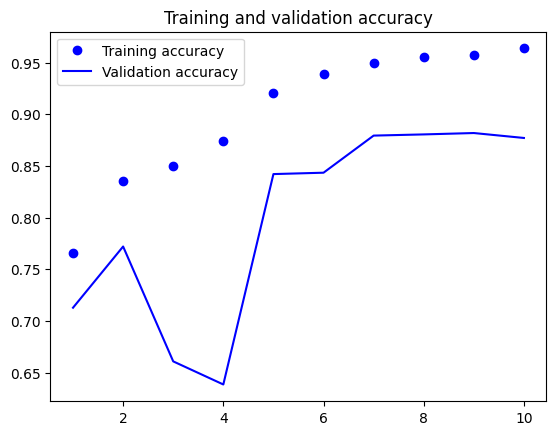

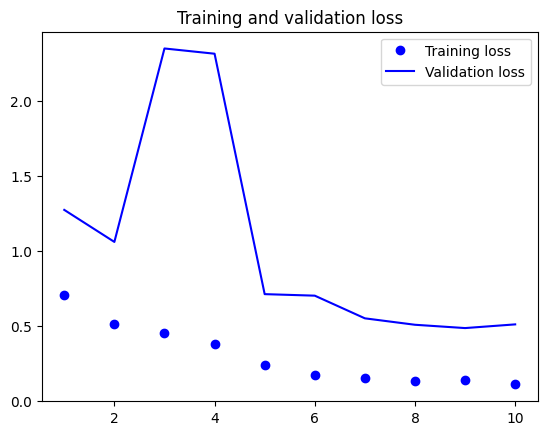

In [ ]:
show_results(history)

## Сохраним модель

In [ ]:
# Saving model

model_two_steps_Animals_10.save(MODELS_DIR.joinpath('model_two_steps_Animals_10.h5'))
print("Модель MobileNetV2_Animals_10 сохранена! ))")

Модель MobileNetV2_Animals_10 сохранена! ))


## Загрузим модель

In [ ]:
model_MobileNetV2_Animals_10 = tf.keras.models.load_model(MODELS_DIR.joinpath('model_two_steps_Animals_10.h5'))   #Загрузим нашу модель

In [ ]:
conv_base = model_MobileNetV2_Animals_10.layers[3]

## Проверка дообученной модели **MobileNetV2**

In [ ]:
test_loss, test_acc = model_MobileNetV2_Animals_10.evaluate(test_ds)   # Проведём тестирование на тестовом dataset
print(f"Test accuracy: {test_acc:.3f}")

164/164 [==============================] - 1772s 11s/step - loss: 0.5022 - sparse_categorical_accuracy: 0.8841
Test accuracy: 0.884


In [ ]:
import time
img, label = next(iter(test_ds))
start_time = time.time()

output = index_to_label[model_MobileNetV2_Animals_10.predict(tf.expand_dims(img[0], 0)).argmax(axis=1)[0]]

delta_time = time.time() - start_time                         # Посчитаем и сохраним, сколько на это ушло времени.

print ("---%s seconds ---" % (delta_time))                    # Выведем сколько секунд.
print( output)

1/1 [==============================] - 1s 1s/step
---1.221649169921875 seconds ---
pecora


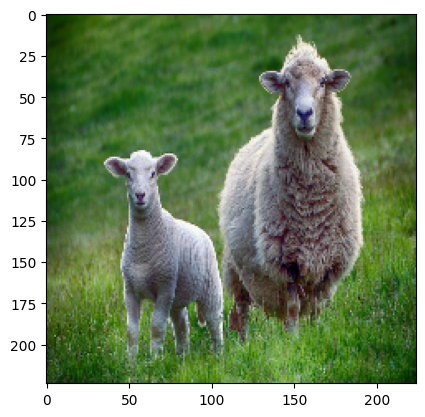

In [ ]:
plt.imshow(img[0].numpy().astype(int))

## Результат теста дообученной модели **MobileNetV2**

In [ ]:
df_results.loc[3] = ['Pretrained_MobileNetV2', test_loss, test_acc, delta_time]
df_results

Model_name      Loss  Accuracy  time_one_jpg
3  Pretrained_MobileNetV2  0.502241  0.884072      1.221649

# **Работа с фича векторами**

### Визуализация качества обучения

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA as sklearnPCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def visualyze_result(df: pd.DataFrame, how: str='pca', figsize=(18,18)):


    lda = LDA(n_components=2) #2-dimensional LDA
    pca = sklearnPCA(n_components=2)
    vectors = np.vstack(df['Vector'].values)
    labels = df['Label_i'].values

    index_to_label = df.groupby('Label_i')['Label'].first()

    if how == 'pca':
        reduced_vector = pd.DataFrame(pca.fit_transform(vectors, labels))
    elif how == 'lda':
        reduced_vector = pd.DataFrame(lda.fit_transform(vectors, labels))
    else:
        return


    plt.figure(figsize=figsize)
    for cls in np.unique(labels):
        plt.scatter(reduced_vector[labels==cls][0], reduced_vector[labels==cls][1], label=f'Class {index_to_label[cls]} - {cls}')
    plt.legend(loc=0)
    plt.show()


In [ ]:
inp = tf.keras.layers.Input(shape=IMAGE_SIZE)                                   # Входной слой
x = tf.keras.layers.Lambda(lambda x: x/255.)(inp)                               # нормализация
outp = conv_base(x)                                                             # Созданный свёрточный слой
# Создаём модель
fv_model = tf.keras.models.Model(inputs=inp, outputs=outp, name='FV_MODEL')
# Смотрим какую модель создали
fv_model.summary()

Model: "FV_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
Total params: 410,208
Trainable params: 310,688
Non-trainable params: 99,520
_________________________________________________________________


In [ ]:
fv_df = pd.DataFrame()                    # Создадим датафрейм для фичивекторов

fv_result = fv_model.predict(test_ds)     # Результирующее предсказание по тестовому датасету
fv_df['Vector'] = list(fv_result)         # Список векторов
fv_df['Label_i'] = test_df['Label_i']     # Метка результата
fv_df['Label'] = test_df['Label']         # Описание метки результата


164/164 [==============================] - 14s 83ms/step


In [ ]:
fv_df

Vector  Label_i       Label
0     [0.10252597, 1.0359106, 0.0, 0.02302355, 0.177...        7      pecora
1     [1.7933874, 1.0295078, 0.0, 0.031857956, 0.0, ...        0        cane
2     [0.47856212, 0.16422614, 0.39349225, 0.8435166...        7      pecora
3     [0.0, 0.0, 0.92171687, 0.20408313, 0.25586307,...        8       ragno
4     [0.2752204, 0.2156244, 0.0, 0.0, 0.06422303, 0...        1     cavallo
...                                                 ...      ...         ...
5231  [0.17092578, 0.0053610606, 0.3385039, 0.265924...        4     gallina
5232  [0.615583, 0.0, 0.93385667, 0.06389128, 2.1829...        1     cavallo
5233  [0.0, 0.0, 0.9631793, 0.0, 0.2609346, 0.0, 0.0...        8       ragno
5234  [0.5889178, 0.06898116, 0.05740633, 0.28638956...        4     gallina
5235  [1.0092275, 0.20288917, 0.47580934, 0.12390611...        9  scoiattolo

[5236 rows x 3 columns]

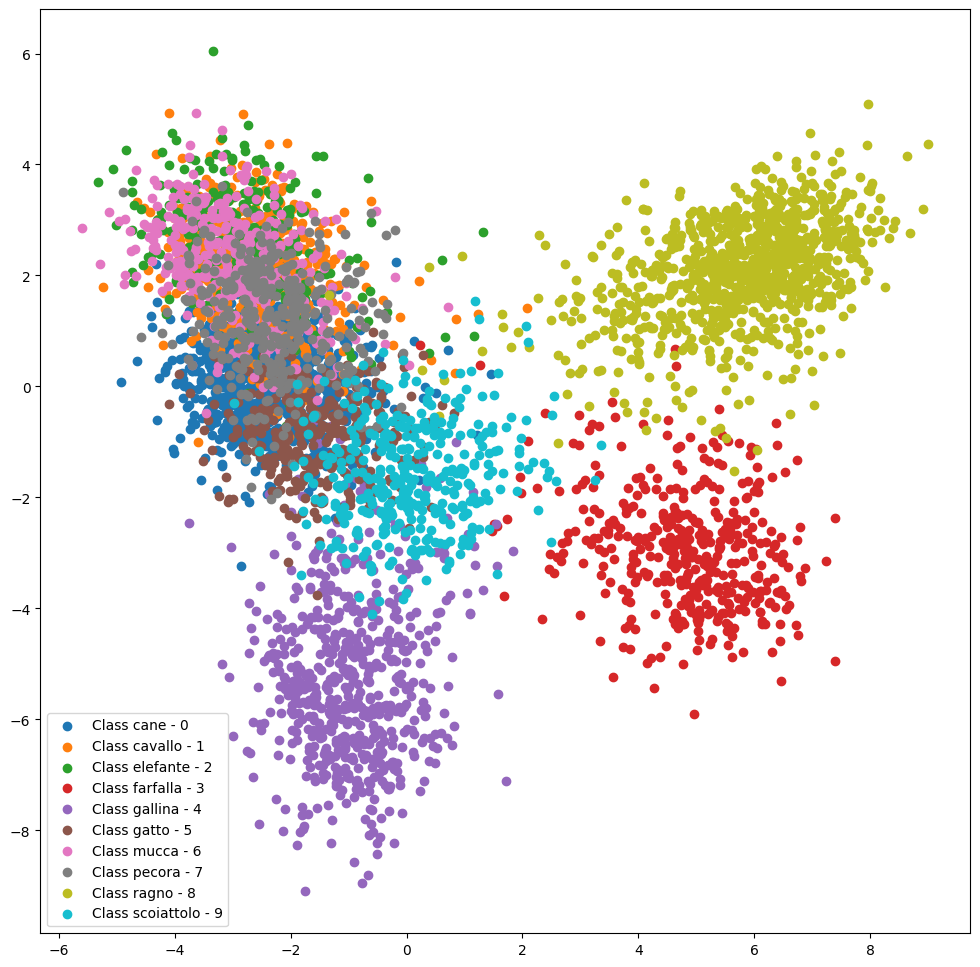

In [ ]:
visualyze_result(fv_df, how='lda', figsize=(12,12) )    # Посмотрим визуализацию.

### Добавляем неизвестные классы нашей сети и смотрим насколько они разнесены с уже известными

In [ ]:
DATASET_DIR.parent.joinpath('new-images')   # Посмотрим путь.


PosixPath('drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataSet/animals-10/new-images')

In [ ]:
newsp_set = [(file.as_posix(), file.parent.name) for file in DATASET_DIR.parent.parent.joinpath('new-images/Bike').glob('**/*.*')] # Добавим класс "Мотоциклы"
newsp_df = pd.DataFrame(data=newsp_set, columns=['File', 'Label'])      # Создадим датафрейм новых неизвестных данных. Из пути файла и названия его папки.
newsp_df['Label_i'] = newsp_df['Label'].astype('category').cat.codes    # Образуем метки из описания меток преобразованием и приведением к типу категорий
newsp_df.head()                                                         # Посмотрим результат.

File Label  Label_i
0  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0
1  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0
2  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0
3  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0
4  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0

In [ ]:
full_df = pd.concat((train_df, val_df, newsp_df), ignore_index=True, axis=0)    # Объединяем три dataframe в один большой, axis=0 - объединение по строкам,
                                                                          # ignore_index = TRUE - переопределение индексов строк в новом объединении.
full_df['Label_i'] = full_df['Label'].astype('category').cat.codes        # Образуем метки из описания меток преобразованием и приведением к типу категорий
full_df['Label'].unique()                                                 # Выведем уникальные значения

array(['gallina', 'gatto', 'scoiattolo', 'farfalla', 'ragno', 'cavallo',
       'mucca', 'cane', 'pecora', 'elefante', 'Bike'], dtype=object)

In [ ]:
full_ds = tf.data.Dataset.from_tensor_slices((full_df['File'].values, full_df['Label_i'].values))   # Создадим
# датасет из двух массивов: значение столбца 'File' и 'Label_i'. Функция from_tensor_slices создаёт датасет, который поочерёдно
# выдаёт элементы из переданных масивов, связывая элементы на соответствующих позициях в каждом массиве между собой в одну запись.
# Таким образом получим датасет содержащий кортежи (имя файла, метка).

full_ds = full_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)
# С помощью метода map применим функцию load_image ко всем данным построчно.
# num_parallel_calls - распаралеливание процессов при подготовки данных
# Размер батча(пачка из n-го количества изображений, что-бы сразу подавать в модель n изображений)
# prefetch - позволяеет подгружать данные наперёд.

print('Размер full_ds = ', len(full_ds))

Размер full_ds =  372


In [ ]:
print(full_df.iloc[365])
print(full_df.iloc[365].File)

File       drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...
Label                                                gallina
Label_i                                                    5
Name: 365, dtype: object
drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataSet/animals-10/raw-img/gallina/OIP-eoEFXIJ3NCt1-QxhanPe0gHaEK.jpeg


In [ ]:
fv_df = pd.DataFrame()                    # Создадим датафрейм для фичивекторов

fv_result = fv_model.predict(full_ds)     # Результирующее предсказание по новому полному датасету
fv_df['Vector'] = list(fv_result)         # Список векторов
fv_df['Label_i'] = full_df['Label_i']     # Метка результата
fv_df['Label'] = full_df['Label']         # Описание метки результата


372/372 [==============================] - 52s 139ms/step


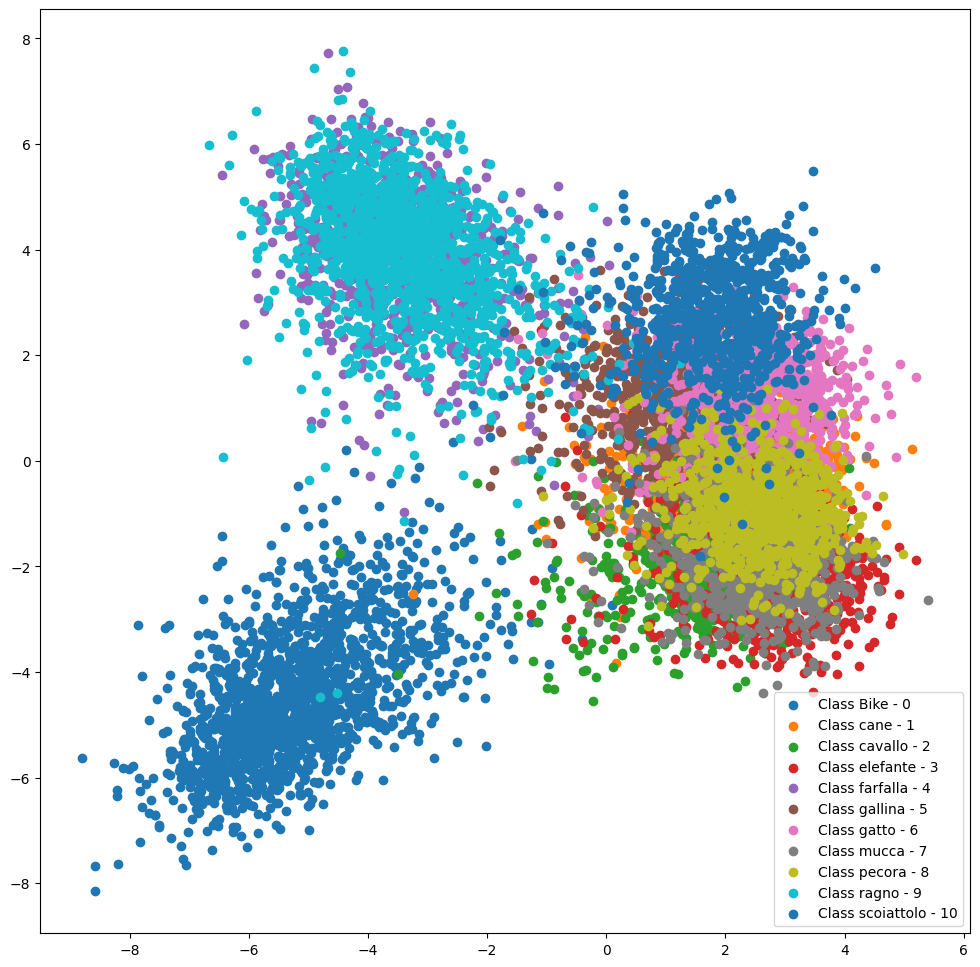

In [ ]:
visualyze_result(fv_df, how='lda', figsize=(12,12) )    # Посмотрим что получилось с новым датафреймом.

На графике видно, что класс car хорошо выделен

### Определение принадлежности к классу используя центроиды классов и измерения расстояния между центроидом и точкой фичавектора исследуемого класса

In [ ]:
# Центроид - это геометрический центр множества точек в многомерном пространстве.
# Центроид можно расчитать для любого множества точек в n-ьерном пространистве путём нахожден ия среднего значения каждой координаты.
# Центроиды всех классов можно определить путём вычисления среднего значения по каждой оси фичавектора для всех объектов в каждом классе.

coordinates = pd.DataFrame(columns=['Vector', 'label_i', 'label', 'radius_max'])  # Создадим датафрайм для координат с такими стобцами.
centers =fv_df.groupby('Label')['Vector'].mean()                                  # Центроиды классов. Группирует значения векторов для каждой метки (Label) и
                                                                                  # находит их среднее значение.
coordinates['Vector'] = centers.values                                            # Это полученные средние значения для каждого центра.
coordinates['label_i'] = coordinates.index                                        # Метка.
coordinates['label'] = centers.keys()                                             # Значение метки.
coordinates.head()                                                                # Посмотрим, что получилось.



Vector  label_i     label  \
0  [0.0941947, 0.06396901, 0.4982448, 0.072045915...        0      Bike   
1  [0.6619375, 0.6735116, 0.25044107, 1.0446844, ...        1      cane   
2  [0.12041427, 0.079911456, 0.4971548, 0.0977134...        2   cavallo   
3  [0.30882862, 0.027732387, 0.7389822, 0.7871442...        3  elefante   
4  [0.0847805, 0.045022774, 1.7197927, 0.27010298...        4  farfalla   

  radius_max  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

In [ ]:
centers

Label
Bike          [0.0941947, 0.06396901, 0.4982448, 0.072045915...
cane          [0.6619375, 0.6735116, 0.25044107, 1.0446844, ...
cavallo       [0.12041427, 0.079911456, 0.4971548, 0.0977134...
elefante      [0.30882862, 0.027732387, 0.7389822, 0.7871442...
farfalla      [0.0847805, 0.045022774, 1.7197927, 0.27010298...
gallina       [0.22648203, 0.097322084, 0.58437604, 0.566924...
gatto         [0.3084032, 0.6414894, 0.59933573, 0.23888123,...
mucca         [0.08450484, 0.25774655, 0.43279308, 0.3664836...
pecora        [0.22926728, 0.2744095, 0.22280934, 0.24526347...
ragno         [0.104299076, 0.03729211, 0.30293363, 0.078274...
scoiattolo    [0.65256864, 0.5089924, 0.3582448, 0.17577852,...
Name: Vector, dtype: object

In [ ]:
len(index_to_label)

10

In [ ]:
#radiuses =[]
for i in range(11):   # Для кадого класса от 0 до 10
  radii = []    # Создаём список с радиусами.
  for vector in fv_df[fv_df['Label_i'] == i]['Vector']:   # Иттерируемся по всем векторам в датафрейме фичавекторов относящихся к конкретному классу.

    radii.append(np.linalg.norm(vector -centers.values[i], ord =2)) # В raddi добавляем расчитанное эвклидовое растояние.
                                                                # Растояние мажду данным вектором из vector и центроидом класса из centers.
  coordinates['radius_max'][i] = (max(radii))   # В датафрейм координат прописываем максимальный радиус из всех радиусов данного класса.

  #radiuses.append(max(radii))   # Добавим новый максимальный радиус
#coordinates['radius_max'] = radiuses    # В датафрейм координат запишем результат



<ipython-input-49-3d3f69b0e6bb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates['radius_max'][i] = (max(radii))   # В датафрейм координат прописываем максимальный радиус из всех радиусов данного класса.


In [ ]:
coordinates.head()    # Посмотрим, что получилось

Vector  label_i     label  \
0  [0.0941947, 0.06396901, 0.4982448, 0.072045915...        0      Bike   
1  [0.6619375, 0.6735116, 0.25044107, 1.0446844, ...        1      cane   
2  [0.12041427, 0.079911456, 0.4971548, 0.0977134...        2   cavallo   
3  [0.30882862, 0.027732387, 0.7389822, 0.7871442...        3  elefante   
4  [0.0847805, 0.045022774, 1.7197927, 0.27010298...        4  farfalla   

  radius_max  
0  31.014227  
1  31.470192  
2   30.28632  
3  31.543093  
4  34.616657

In [ ]:
bike_test_set = [(file.as_posix(), file.parent.name) for file in DATASET_DIR.parent.parent.joinpath('test/Bike').glob('**/*.*')] # загрузим тестовые
                                                                                # изображения мотоциклов
bike_test_df = pd.DataFrame(data=bike_test_set, columns=['File', 'Label'])  # Создадим датафрейм новых неизвестных данных. Из пути файла и названия его папки.
bike_test_df['Label_i'] = newsp_df['Label'].astype('category').cat.codes    # Образуем метки из описания меток преобразованием и приведением к типу категорий
#bike_test_df.tail()
bike_test_df.head()


File Label  Label_i
0  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0
1  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0
2  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0
3  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0
4  drive/MyDrive/Colab Notebooks/CV/CV_HW_2/DataS...  Bike        0

In [ ]:
full_test_df = pd.concat((test, bike_test_df), ignore_index=True)               # Объединяем три dataframe в один большой, axis=0 - объединение по строкам,
                                                                                # ignore_index = TRUE - переопределение индексов строк в новом объединении.
full_test_df['Label_i'] = full_test_df['Label'].astype('category').cat.codes    # Образуем метки из описания меток преобразованием и приведением к типу категорий
full_test_df['Label'].unique()                                                  # Выведем уникальные значения

array(['pecora', 'cane', 'ragno', 'cavallo', 'farfalla', 'scoiattolo',
       'gatto', 'gallina', 'elefante', 'mucca', 'Bike'], dtype=object)

In [ ]:
full_test_ds = tf.data.Dataset.from_tensor_slices((full_test_df['File'].values, full_test_df['Label_i'].values))  # Создадим
# датасет из двух массивов: значение столбца 'File' и 'Label_i'. Функция from_tensor_slices создаёт датасет, который поочерёдно
# выдаёт элементы из переданных масивов, связывая элементы на соответствующих позициях в каждом массиве между собой в одну запись.
# Таким образом получим датасет содержащий кортежи (имя файла, метка).
full_test_ds = full_test_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)
# С помощью метода map применим функцию load_image ко всем данным построчно.
# num_parallel_calls - распаралеливание процессов при подготовки данных
# Размер батча(пачка из n-го количества изображений, что-бы сразу подавать в модель n изображений)
# prefetch - позволяеет подгружать данные наперёд.

print('Размер full_ds = ', len(full_test_ds))

Размер full_ds =  169


In [ ]:
fv_test_df = pd.DataFrame()                           # Создадим датафрейм для фичивекторов

fv_test_result = fv_model.predict(full_test_ds)       # Результирующее предсказание по новому полному датасету
fv_test_df['Vector'] = list(fv_test_result)           # Список векторов
fv_test_df['Label_i'] = full_test_df['Label_i']       # Метка результата
fv_test_df['Label'] = full_test_df['Label']           # Описание метки результата

169/169 [==============================] - 65s 386ms/step


In [ ]:

import cv2

img = cv2.imread(DATASET_DIR.parent.parent.joinpath('test/Bike/Bike (308).jpeg').as_posix())  # Открываем тестовое изображение и преобразуем в матрицу пикселей.
img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)   # Изменяем размер изображениия приодя его к 224 на 224, используя метод интерполяции INTER_AREA.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # Изменим цветовое пространство изображения из BGR в более часто используемое RGB.
# Получим векторное представление модели изображения.
vector = fv_model.predict(np.expand_dims(img,0))[0]   # Оборачиваем матрицу пикселей в массив, и добавляем ещё одно измерение.
vector

1/1 [==============================] - 1s 726ms/step


array([0.00759882, 0.6262958 , 1.0894216 , ..., 0.07775226, 0.04303469,
       0.92481214], dtype=float32)

In [ ]:
coordinates.iloc[1]['label']    # Посмотрим одно значение с меткой

'cane'

In [ ]:
fv_test_df

Vector  Label_i    Label
0     [0.10252597, 1.0359106, 0.0, 0.02302355, 0.177...        8   pecora
1     [1.7933874, 1.0295078, 0.0, 0.031857956, 0.0, ...        1     cane
2     [0.47856212, 0.16422614, 0.39349225, 0.8435166...        8   pecora
3     [0.0, 0.0, 0.92171687, 0.20408313, 0.25586307,...        9    ragno
4     [0.2752204, 0.2156244, 0.0, 0.0, 0.06422303, 0...        2  cavallo
...                                                 ...      ...      ...
5382  [0.35719207, 0.0, 0.43486547, 0.0, 0.577709, 0...        0     Bike
5383  [0.0, 0.33950552, 1.9832315, 0.535249, 0.03231...        0     Bike
5384  [0.0, 0.017468374, 0.6444419, 0.0, 0.033020716...        0     Bike
5385  [0.0, 0.0, 0.78927356, 0.010350545, 0.4279244,...        0     Bike
5386  [0.0, 0.0, 1.2192987, 0.0, 0.18089886, 0.03614...        0     Bike

[5387 rows x 3 columns]

In [ ]:
coordinates.iloc[1]   #  # Посмотрим одно значение датафрейма с координатами.

Vector        [0.6619375, 0.6735116, 0.25044107, 1.0446844, ...
label_i                                                       1
label                                                      cane
radius_max                                            31.470192
Name: 1, dtype: object

In [ ]:

res_df = pd.DataFrame
coordinates['false_predicted'],  coordinates['true_predicted']= 0, 0    # Устанавливаем два столбца.

for index, row in fv_test_df.iterrows():    # Пройдём по каждой строке датафрейма(векторные представления изображения и соответсвующие метки)
                                            # row - вектора изображений, index - метки изображений.
  distances = []    # Создадим список растояний.
  for centroid in centers.values:    # Проходимся по всем классам с их центроидами
  # и для кажддого класса посчитаем эвклидово растояние до текущего вектора, а потом выберем минимальное значение.
    distances.append(np.linalg.norm(row.Vector - centroid, ord=2)) # В distanse добавляем расчитанное эвклидовое растояние.
                                                                # Растояние мажду данным вектором из vector и центроидом класса из centers.
  distances_min = coordinates.iloc[np.argmin(distances)] # Найдём из всех растояний, минимальное от вектора до центроида.

  if (distances_min['label'] == row.Label # Если найденный клас равен предсказанному класу в датафрейме
      and np.linalg.norm(row.Vector - distances_min['Vector'], ord=2) < distances_min['radius_max']): # минимальный радиус от вектора
      # до центроида не превышает максимальный радиус для данного класса, то предсказали правильно.

    coordinates['true_predicted'][np.argmin(distances)] = coordinates['true_predicted'][np.argmin(distances)] + 1   # Правильно предсказаннй клас +1
  else:
    coordinates['false_predicted'][row.Label_i] = coordinates['false_predicted'][row.Label_i] + 1 # Неправильно предсказанный клас +1


<ipython-input-70-3c30784a609c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates['true_predicted'][np.argmin(distances)] = coordinates['true_predicted'][np.argmin(distances)] + 1   # Правильно предсказаннй клас +1
<ipython-input-70-3c30784a609c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates['false_predicted'][row.Label_i] = coordinates['false_predicted'][row.Label_i] + 1 # Неправильно предсказанный клас +1


In [ ]:
coordinates   # Посмотрим результат

Vector  label_i       label  \
0   [0.0941947, 0.06396901, 0.4982448, 0.072045915...        0        Bike   
1   [0.6619375, 0.6735116, 0.25044107, 1.0446844, ...        1        cane   
2   [0.12041427, 0.079911456, 0.4971548, 0.0977134...        2     cavallo   
3   [0.30882862, 0.027732387, 0.7389822, 0.7871442...        3    elefante   
4   [0.0847805, 0.045022774, 1.7197927, 0.27010298...        4    farfalla   
5   [0.22648203, 0.097322084, 0.58437604, 0.566924...        5     gallina   
6   [0.3084032, 0.6414894, 0.59933573, 0.23888123,...        6       gatto   
7   [0.08450484, 0.25774655, 0.43279308, 0.3664836...        7       mucca   
8   [0.22926728, 0.2744095, 0.22280934, 0.24526347...        8      pecora   
9   [0.104299076, 0.03729211, 0.30293363, 0.078274...        9       ragno   
10  [0.65256864, 0.5089924, 0.3582448, 0.17577852,...       10  scoiattolo   

   radius_max  false_predicted  true_predicted  
0   31.014227                4             147  
1   31.470192              136             836  
2    30.28632              114             410  
3   31.543093               38             251  
4   34.616657               43             380  
5   39.184753               82             537  
6   31.368181               62             272  
7   27.757818               53             321  
8   34.202003               70             294  
9   30.641624               59             905  
10  28.125095               38             335

В результате, видно, что 4 мотоцикла предсказанны неверно.

In [ ]:
import tensorflow as tf

In [ ]:
# метод уменьшения размерности вектора до 160
def reshape_vector(df):
  reshaped_vectors = []   # Создадим массив для преобразованных вкторов
  for i, vector in enumerate(df['Vector']):  # Переберём вектора 'Vector' в поступившем датафрейме
    reshaped_vector = tf.reshape(vector, [1, 1280, 1])    # Вместо одномерного вектора длины 1280 получим тримерный тензор
                                                          # размерности [1, 1280, 1]
    max_pool_1d = tf.keras.layers.MaxPooling1D(pool_size=8)   # Инициализируем слой MaxPooling1D с переменной max_pool_1d
    max_pooling_1D = max_pool_1d(reshaped_vector)             # сделаем максимальный сбор 8 элементов, и как резултат тензор [1, 160,1]
    reshaped_vectors.append(tf.reshape(max_pooling_1D, (-1,)).numpy()) # получаем одномерный вектор (из многомерного массива).
  df['reshaped_vector'] = reshaped_vectors    # Сохраним в новой колонке в датафрейме

In [ ]:
# Преобразуем датафреймы
reshape_vector(fv_df)
reshape_vector(fv_test_df)

In [ ]:
print('длина fv_df =', len(fv_df['reshaped_vector'][0]))
print('Длина fv_test_df =', len(fv_test_df['reshaped_vector'][0]))

длина fv_df = 160
Длина fv_test_df = 160


In [ ]:
# посчитаем новые центроиды
centers = fv_df.groupby('Label')['reshaped_vector'].mean()                  # Центроиды классов. Группирует значения векторов для каждой метки (Label) и
                                                                            # находит их среднее значение.
coordinates['Vector_new'] = centers.values                                  # Это полученные средние значения для каждого нового центра.
coordinates.head(11)                                                        # Посмотрим, что получилось.


Vector  label_i       label  \
0   [0.0941947, 0.06396901, 0.4982448, 0.072045915...        0        Bike   
1   [0.6619375, 0.6735116, 0.25044107, 1.0446844, ...        1        cane   
2   [0.12041427, 0.079911456, 0.4971548, 0.0977134...        2     cavallo   
3   [0.30882862, 0.027732387, 0.7389822, 0.7871442...        3    elefante   
4   [0.0847805, 0.045022774, 1.7197927, 0.27010298...        4    farfalla   
5   [0.22648203, 0.097322084, 0.58437604, 0.566924...        5     gallina   
6   [0.3084032, 0.6414894, 0.59933573, 0.23888123,...        6       gatto   
7   [0.08450484, 0.25774655, 0.43279308, 0.3664836...        7       mucca   
8   [0.22926728, 0.2744095, 0.22280934, 0.24526347...        8      pecora   
9   [0.104299076, 0.03729211, 0.30293363, 0.078274...        9       ragno   
10  [0.65256864, 0.5089924, 0.3582448, 0.17577852,...       10  scoiattolo   

   radius_max  false_predicted  true_predicted  \
0   31.014227                4             147   
1   31.470192              136             836   
2    30.28632              114             410   
3   31.543093               38             251   
4   34.616657               43             380   
5   39.184753               82             537   
6   31.368181               62             272   
7   27.757818               53             321   
8   34.202003               70             294   
9   30.641624               59             905   
10  28.125095               38             335   

                                           Vector_new  
0   [1.1852841, 1.1179782, 0.77605546, 1.9570206, ...  
1   [1.822744, 1.3794261, 1.6234639, 2.0811386, 1....  
2   [1.4986376, 0.8363012, 1.6945276, 2.0461397, 1...  
3   [1.5180408, 1.1668541, 1.0613422, 1.2325399, 2...  
4   [1.9017658, 1.1385885, 0.89748424, 2.2552273, ...  
5   [1.5126245, 1.5153137, 1.5559461, 1.9316069, 1...  
6   [1.2924705, 1.2736135, 1.5609733, 1.6539705, 1...  
7   [1.2594825, 0.938377, 1.5592039, 1.8435426, 1....  
8   [1.1805483, 1.1702265, 1.3512225, 1.5594648, 1...  
9   [0.97920316, 1.3807983, 1.2125509, 2.81236, 1....  
10  [1.4867624, 1.6640378, 1.2241277, 1.4637868, 2...

In [ ]:
# посчитаем новые максимальные радиусы
radiuses_max_new=[]
for i in range(11):   # Для кадого класса от 0 до 10
  radii_new = []    # Создаём список с радиусами.
  for vector in fv_df[fv_df['Label_i'] == i]['reshaped_vector']:# Иттерируемся по всем векторам в датафрейме фичавекторов относящихся к конкретному классу.
    radii_new.append(np.linalg.norm(vector - coordinates['Vector_new'][i], ord =2)) # В raddi_new добавляем расчитанное эвклидовое растояние.
                                                                # Растояние мажду данным вектором из vector и новым центроидом класса.

  radiuses_max_new.append(max(radii_new))   # Добавим новый максимальный радиус
coordinates['radius_max_new'] = radiuses_max_new    # В датафрейм координат запишем результат




In [ ]:
coordinates

Vector  label_i       label  \
0   [0.44386664, 0.11952361, 0.41103762, 1.6982229...        0        cane   
1   [0.118251085, 0.014930415, 1.6760302, 1.646806...        1         car   
2   [1.0229499, 0.034447484, 0.9879772, 0.75673753...        2     cavallo   
3   [0.5435419, 0.0069711874, 0.6853541, 2.210668,...        3    elefante   
4   [0.10394808, 0.009048787, 1.7517567, 1.4063368...        4    farfalla   
5   [0.3007296, 0.017965162, 0.5452897, 1.311706, ...        5     gallina   
6   [0.08483198, 0.12137318, 0.3667119, 1.024204, ...        6       gatto   
7   [0.50639814, 0.036642864, 0.7168784, 1.7509228...        7       mucca   
8   [0.25419214, 0.03303789, 0.4837357, 1.9746151,...        8      pecora   
9   [0.1405747, 0.024546072, 0.690659, 1.3428843, ...        9       ragno   
10  [0.25243416, 0.07105101, 0.39155185, 1.5717449...       10  scoiattolo   

   max_radius  false_predicted  true_predicted  \
0    36.77824               67             237   
1   35.603851                0             266   
2   35.246006               41             123   
3    35.36644               14              76   
4   51.739517               19             113   
5   43.340115               31             163   
6    37.28614               22              82   
7   33.502651               37              80   
8   35.622272               30              84   
9    38.12606               30             272   
10  32.579758               11             105   

                                           new_center  new_max_radius  
0   [4.026512, 2.3794415, 2.8269386, 2.736078, 3.5...       21.390263  
1   [2.3843718, 1.4383239, 2.7895696, 1.557521, 2....       20.446175  
2   [2.628487, 1.5785137, 2.7358313, 2.0755303, 2....       15.692978  
3   [2.573388, 1.3810757, 1.7156252, 0.97576517, 3...       19.799232  
4   [2.8656077, 2.4202428, 3.692307, 3.0504498, 2....       27.640772  
5   [3.790594, 2.2108474, 2.4861863, 2.8951173, 2....       24.301477  
6   [4.3039513, 2.856675, 2.011139, 2.6106508, 4.1...       20.611975  
7   [2.4745896, 1.7472316, 2.5401065, 1.6663586, 2...       15.708850  
8   [2.5900786, 2.0350323, 2.0700371, 1.4844428, 2...       15.560573  
9   [3.162072, 2.291482, 2.7529542, 2.7246618, 2.4...       21.001900  
10  [3.949205, 2.580828, 2.2298024, 2.1201124, 2.8...       15.156299

In [ ]:

res_df = pd.DataFrame
coordinates['false_predicted_new'],  coordinates['true_predicted_new']= 0, 0    # Устанавливаем два столбца.

for index, row in fv_test_df.iterrows():    # Пройдём по каждой строке датафрейма(векторные представления изображения и соответсвующие метки)
                                            # row - вектора изображений, index - метки изображений.
  distances = []    # Создадим список растояний.
  for centroid in coordinates['Vector_new']:    # Проходимся по всем классам с их центроидами
  # и для кажддого класса посчитаем эвклидово растояние до текущего вектора, а потом выберем минимальное значение.
    distances.append(np.linalg.norm(row.reshaped_vector - centroid, ord=2)) # В distanse добавляем расчитанное эвклидовое растояние.
                                                                # Растояние мажду данным вектором из vector и центроидом класса из centers.
  distances_min = coordinates.iloc[np.argmin(distances)] # Найдём из всех растояний, минимальное от вектора до центроида.

  if (distances_min['label'] == row.Label # Если найденный клас равен предсказанному класу в датафрейме
      and np.linalg.norm(row.reshaped_vector - distances_min['Vector_new'], ord=2) < distances_min['radius_max_new']): # минимальный радиус от вектора
      # до центроида не превышает максимальный радиус для данного класса, то предсказали правильно.

    coordinates['true_predicted_new'][np.argmin(distances)] = coordinates['true_predicted_new'][np.argmin(distances)] + 1   # Правильно предсказаннй клас +1
  else:
    coordinates['false_predicted_new'][row.Label_i] = coordinates['false_predicted_new'][row.Label_i] + 1 # Неправильно предсказанный клас +1from scipy.spatial import distance




<ipython-input-106-e71819b5f30c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates['true_predicted_new'][np.argmin(distances)] = coordinates['true_predicted_new'][np.argmin(distances)] + 1   # Правильно предсказаннй клас +1
<ipython-input-106-e71819b5f30c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates['false_predicted_new'][row.Label_i] = coordinates['false_predicted_new'][row.Label_i] + 1 # Неправильно предсказанный клас +1from scipy.spatial import distance


In [ ]:
coordinates

Vector  label_i       label  \
0   [0.0941947, 0.06396901, 0.4982448, 0.072045915...        0        Bike   
1   [0.6619375, 0.6735116, 0.25044107, 1.0446844, ...        1        cane   
2   [0.12041427, 0.079911456, 0.4971548, 0.0977134...        2     cavallo   
3   [0.30882862, 0.027732387, 0.7389822, 0.7871442...        3    elefante   
4   [0.0847805, 0.045022774, 1.7197927, 0.27010298...        4    farfalla   
5   [0.22648203, 0.097322084, 0.58437604, 0.566924...        5     gallina   
6   [0.3084032, 0.6414894, 0.59933573, 0.23888123,...        6       gatto   
7   [0.08450484, 0.25774655, 0.43279308, 0.3664836...        7       mucca   
8   [0.22926728, 0.2744095, 0.22280934, 0.24526347...        8      pecora   
9   [0.104299076, 0.03729211, 0.30293363, 0.078274...        9       ragno   
10  [0.65256864, 0.5089924, 0.3582448, 0.17577852,...       10  scoiattolo   

   radius_max  false_predicted  true_predicted  \
0   31.014227                4             147   
1   31.470192              136             836   
2    30.28632              114             410   
3   31.543093               38             251   
4   34.616657               43             380   
5   39.184753               82             537   
6   31.368181               62             272   
7   27.757818               53             321   
8   34.202003               70             294   
9   30.641624               59             905   
10  28.125095               38             335   

                                           Vector_new  radius_max_new  \
0   [1.1852841, 1.1179782, 0.77605546, 1.9570206, ...       22.015829   
1   [1.822744, 1.3794261, 1.6234639, 2.0811386, 1....       17.826345   
2   [1.4986376, 0.8363012, 1.6945276, 2.0461397, 1...       14.266058   
3   [1.5180408, 1.1668541, 1.0613422, 1.2325399, 2...       20.437029   
4   [1.9017658, 1.1385885, 0.89748424, 2.2552273, ...       23.707479   
5   [1.5126245, 1.5153137, 1.5559461, 1.9316069, 1...       25.403748   
6   [1.2924705, 1.2736135, 1.5609733, 1.6539705, 1...       19.799328   
7   [1.2594825, 0.938377, 1.5592039, 1.8435426, 1....       14.000463   
8   [1.1805483, 1.1702265, 1.3512225, 1.5594648, 1...       17.690033   
9   [0.97920316, 1.3807983, 1.2125509, 2.81236, 1....       18.522385   
10  [1.4867624, 1.6640378, 1.2241277, 1.4637868, 2...       14.692304   

    false_predicted_new  true_predicted_new  
0                     7                 144  
1                   206                 766  
2                   156                 368  
3                    88                 201  
4                    92                 331  
5                   124                 495  
6                   104                 230  
7                    87                 287  
8                   114                 250  
9                   158                 806  
10                   71                 302

В результате, видно, что когда мы уменьшили размерность вектора, то неверных предсказаний стало больше.